In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json


# Point this path to where you unzipped the clinical_trial_risk repository
REPO_DIR = "/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk"
sys.path.append(REPO_DIR + "/front_end")

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


In [2]:
MODELS_DIR = REPO_DIR + '/front_end/models/'

In [3]:
from util.page_tokeniser import tokenise_pages

In [4]:
from processors.phase_extractor_rule_based import PhaseExtractorRuleBased

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-11-21 21:19:30.255596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 21:19:30.413369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file:

In [5]:
from processors.phase_extractor_spacy import PhaseExtractorSpacy

In [6]:
phase_extractor = PhaseExtractorRuleBased(MODELS_DIR + "phase_rf_classifier.pkl.bz2")

Initialising Phase Random Forest classifier /media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/clinical_trial_risk/front_end/models/phase_rf_classifier.pkl.bz2


In [7]:
phase_extractor_spacy = PhaseExtractorSpacy(MODELS_DIR + "spacy-textcat-phase-04-model-best")

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [8]:
df_train = df_annotations[df_annotations.train_val == "val"]

In [9]:
df_train_small = df_train[~df_train.phase.isna()].sample(100)

In [10]:
texts =[]
for i in range(len(df_train_small)):
    file_name = df_train_small.file.iloc[i]

    with open("/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/data_open/read_ctgov_data/json/" + file_name + ".json", "r", encoding="utf-8") as f:
        pages = json.load(f)
    texts.append(pages)
df_train_small["pages"] = texts

In [11]:
pred1 = []
pred2 = []


y1 = []
y2 = []
for idx in range(len(df_train_small)):
    tokenised_pages = tokenise_pages(df_train_small.pages.iloc[idx])
    
    subj_to_pages = phase_extractor.process(tokenised_pages)
    pred1.append(subj_to_pages["prediction"])
    y1.append(subj_to_pages["probas"])
    
    subj_to_pages_nb = phase_extractor_spacy.process(tokenised_pages)
    pred2.append(subj_to_pages_nb["prediction"])
    y2.append(subj_to_pages_nb["probas"])


In [12]:
df_train_small["y1"] = y1
df_train_small["y2"] = y2


In [13]:
df_train_small["y1_pred"] = pred1
df_train_small["y2_pred"] = pred2


In [14]:
df_train_small["y2"].iloc[idx]

{'Phase 0.5': 0.004506488796323538,
 'Phase 0': 0.007554365321993828,
 'Phase 1': 0.29411497712135315,
 'Phase 1.5': 0.33038923144340515,
 'Phase 2': 0.27754080295562744,
 'Phase 2.5': 0.011906971223652363,
 'Phase 3': 0.03371482342481613,
 'Phase 4': 0.04027237370610237}

In [64]:
probas3 = []
for idx in range(len(df_train_small)):
    combined_probas = {}
    rule_based = df_train_small["y1"].iloc[idx]
    
    if len(rule_based) > 0:
        for i, p in rule_based.items():
            # Multiply by number of arms if applicable
    #         if i in num_subjects_to_pages["is_per_arm"]:
    #             i *= num_arms_to_pages["prediction"]
            combined_probas[i] = (p + df_train_small["y2"].iloc[idx][i]) / 2
    else:
        combined_probas = df_train_small["y2"].iloc[idx]
    
    
    probas3.append(combined_probas)
df_train_small["y3"] = probas3

In [65]:
df_train_small.head()[["nct_id", "phase", "y1_pred"]]

,nct_id,phase,y1_pred
4046,NCT01854034,Phase 2,2.0
679,NCT03877705,Early Phase 1,0.0
5126,NCT04854642,Phase 1,1.0
6388,NCT02845453,Phase 4,0.0
9003,NCT03815175,Not Applicable,0.0


In [66]:
df_train_small["y2"].iloc[11]

{'Phase 0.5': 0.011255140416324139,
 'Phase 0': 0.022474566474556923,
 'Phase 1': 0.2581557631492615,
 'Phase 1.5': 0.11796849220991135,
 'Phase 2': 0.23751261830329895,
 'Phase 2.5': 0.023551031947135925,
 'Phase 3': 0.15256990492343903,
 'Phase 4': 0.17651249468326569}

In [67]:
df_train_small["y3_pred"] = df_train_small["y3"].apply(lambda x : max(x, key=x.get) if len(x) > 0 else "Phase 0"). \
    apply(lambda x : float(re.sub(r'Phase ', '', x)))

In [68]:
df_train_small[["file", "phase", "y1_pred"]]

,file,phase,y1_pred
4046,34_NCT01854034_Prot_SAP_000.pdf,Phase 2,2.0
679,05_NCT03877705_Prot_000.pdf,Early Phase 1,0.0
5126,42_NCT04854642_Prot_000.pdf,Phase 1,1.0
6388,53_NCT02845453_Prot_SAP_001.pdf,Phase 4,0.0
9003,75_NCT03815175_Prot_000.pdf,Not Applicable,0.0
...,...,...,...
678,05_NCT03824405_Prot_000.pdf,Phase 2,2.0
11904,99_NCT03818399_Prot_SAP_000.pdf,Phase 3,3.0
1713,14_NCT02802514_Prot_000.pdf,Phase 4,4.0
708,06_NCT01878006_Prot_SAP_000.pdf,Phase 2,2.0


In [69]:
phase_map = {'Early Phase 1':0.5,
 'Not Applicable':0,
 'Phase 1':1,
 'Phase 1/Phase 2':1.5,
 'Phase 2':2,
 'Phase 2/Phase 3':2.5,
 'Phase 3':3,
 'Phase 4':4}

In [70]:
accuracy_score( df_train_small.phase.map(phase_map).apply(str), df_train_small.y1_pred.apply(str))

0.68

In [71]:
accuracy_score( df_train_small.phase.map(phase_map).apply(str), df_train_small.y2_pred.apply(str))

0.48

In [72]:
accuracy_score( df_train_small.phase.map(phase_map).apply(str), df_train_small.y3_pred.apply(str))

0.7

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

''

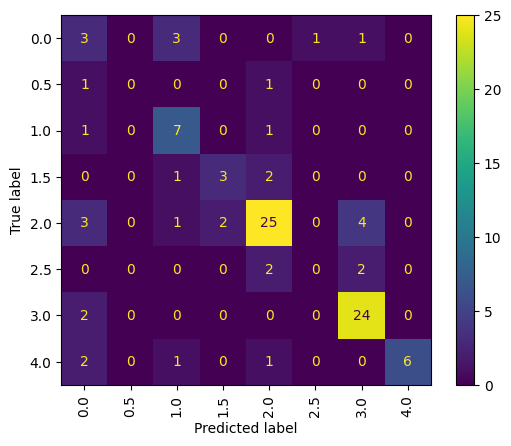

In [74]:
ConfusionMatrixDisplay.from_predictions(df_train_small.phase.map(phase_map).apply(str), df_train_small.y1_pred.apply(str))
plt.xticks(rotation=90)
;

''

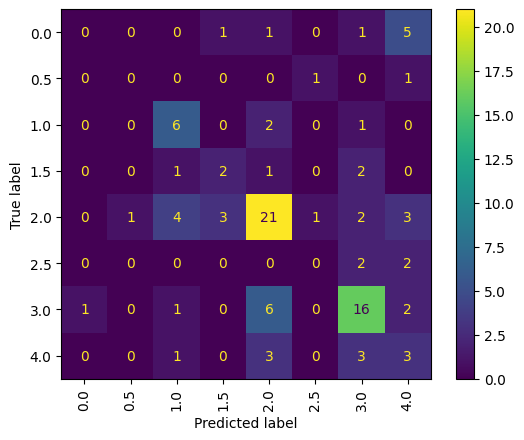

In [75]:
ConfusionMatrixDisplay.from_predictions(df_train_small.phase.map(phase_map).apply(str), df_train_small.y2_pred.apply(str))
plt.xticks(rotation=90)
;

''

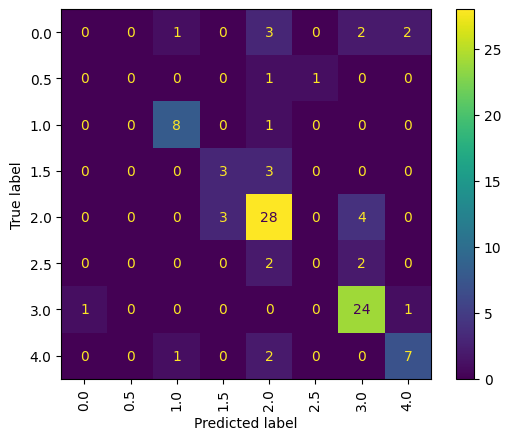

In [76]:
ConfusionMatrixDisplay.from_predictions(df_train_small.phase.map(phase_map).apply(str), df_train_small.y3_pred.apply(str))
plt.xticks(rotation=90)
;

In [77]:
import matplotlib.pyplot as plt

In [43]:
df_train_small.y1.iloc[0]

{'Phase 1': 0.07, 'Phase 2': 0.68, 'Phase 3': 0.02}

In [44]:
from sklearn.metrics import roc_auc_score
for model in [1,2,3]:
    all_aucs = []
    for phase in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "4.0"]:
        roc_auc = roc_auc_score(df_train_small.phase.map(phase_map).apply(str) == phase, 
                                df_train_small[f"y{model}"].apply(lambda m : m.get("Phase " + re.sub(r"\.0", "", phase), 0)))
        print (f"ROC AUC {roc_auc} for model {model} arms Phase {phase}")
        all_aucs.append(roc_auc)
    print (f"Average model {model}", np.mean(all_aucs))

ROC AUC 0.5 for model 1 arms Phase 0.0
ROC AUC 0.5 for model 1 arms Phase 0.5
ROC AUC 0.8846153846153846 for model 1 arms Phase 1.0
ROC AUC 0.9689716312056738 for model 1 arms Phase 1.5
ROC AUC 0.8028571428571429 for model 1 arms Phase 2.0
ROC AUC 0.484375 for model 1 arms Phase 2.5
ROC AUC 0.9472453222453223 for model 1 arms Phase 3.0
ROC AUC 0.8444444444444443 for model 1 arms Phase 4.0
Average model 1 0.7415636156709959
ROC AUC 0.75 for model 2 arms Phase 0.0
ROC AUC 0.9081632653061225 for model 2 arms Phase 0.5
ROC AUC 0.8766788766788767 for model 2 arms Phase 1.0
ROC AUC 0.7641843971631205 for model 2 arms Phase 1.5
ROC AUC 0.7951648351648352 for model 2 arms Phase 2.0
ROC AUC 0.671875 for model 2 arms Phase 2.5
ROC AUC 0.8232848232848233 for model 2 arms Phase 3.0
ROC AUC 0.7433333333333334 for model 2 arms Phase 4.0
Average model 2 0.7915855663663889
ROC AUC 0.6317934782608696 for model 3 arms Phase 0.0
ROC AUC 0.7219387755102041 for model 3 arms Phase 0.5
ROC AUC 0.995115995115

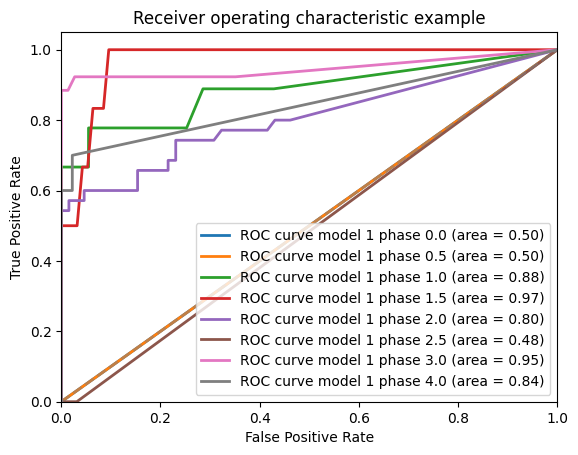

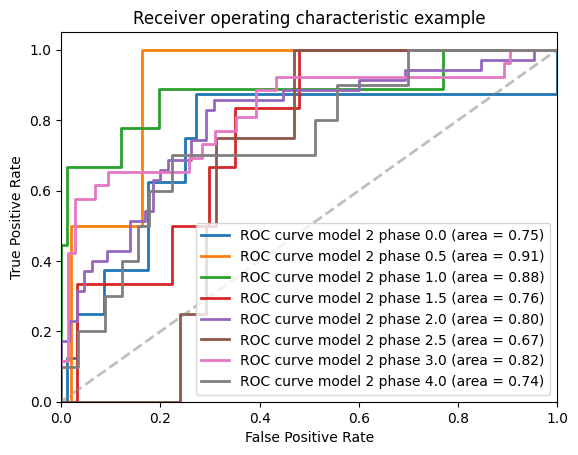

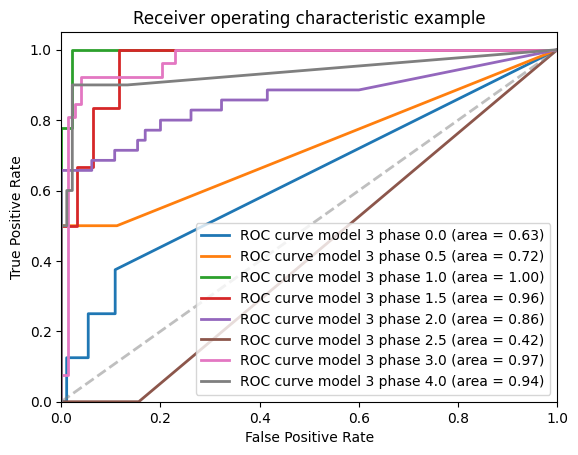

In [46]:
plt.figure()
lw = 2
    
for model in [1,2,3]:
    all_aucs = []
    for phase in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "4.0"]:
        fpr, tpr, _ = roc_curve(df_train_small.phase.map(phase_map).apply(str) == phase, 
                                df_train_small[f"y{model}"].apply(lambda m : m.get("Phase " + re.sub(r"\.0", "", phase), 0)))
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            # color="darkorange",
            lw=lw,
            label=f"ROC curve model {model} phase {phase} (area = {roc_auc:0.2f})"
        )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()